# Imports

In [59]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr 14 13:16:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   2407MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [60]:
pip install transformers

In [0]:
pip install rouge

In [0]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
import time
import spacy
import torch
import sys
import random 
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adagrad
import numpy as np
from collections import Counter
from torch.autograd import Variable
import time
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from torch.utils.data import RandomSampler, DataLoader, TensorDataset, random_split
import copy
from tqdm.notebook import tqdm
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence       
from rouge import FilesRouge
import matplotlib.pyplot as plt

In [0]:
# Set device for switching between CPU and GPU.
device = 'cuda'

In [63]:
# Mount google drive to access files.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

In [64]:
# Import dataset from online.
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2020-04-14 13:16:32--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz.1’

Software_5.json.gz. 100%[===================>]   5.09M  8.34MB/s    in 0.6s    

2020-04-14 13:16:33 (8.34 MB/s) - ‘Software_5.json.gz.1’ saved [5339013/5339013]



In [65]:
dataset = []
with gzip.open('Software_5.json.gz') as f:
    for l in f:
        dataset.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(dataset))

# first row of the list
print(dataset[0])

12805
{'overall': 4.0, 'verified': False, 'reviewTime': '10 20, 2010', 'reviewerID': 'A38NELQT98S4H8', 'asin': '0321719816', 'style': {'Format:': ' DVD-ROM'}, 'reviewerName': 'WB Halper', 'reviewText': "I've been using Dreamweaver (and it's predecessor Macromedia's UltraDev) for many years.  For someone who is an experienced web designer, this course is a high-level review of the CS5 version of Dreamweaver, but it doesn't go into a great enough level of detail to find it very useful.\n\nOn the other hand, this is a great tool for someone who is a relative novice at web design.  It starts off with a basic overview of HTML and continues through the concepts necessary to build a modern web site.  Someone who goes through this course should exit with enough knowledge to create something that does what you want it do do...within reason.  Don't expect to go off and build an entire e-commerce system with only this class under your belt.\n\nIt's important to note that there's a long gap from s

In [66]:
# Convert dictionary into pandas dataframe.
data = pd.DataFrame.from_dict(dataset)

print(len(data))

12805


In [67]:
# Check for null values.
data.isnull().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
style              5644
reviewerName          9
reviewText            1
summary               6
unixReviewTime        0
vote               8903
image             12734
dtype: int64

In [0]:
# Remove null values and unneeded features.
data = data.drop(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'unixReviewTime', 'vote',
       'image'], 1)
data = data.reset_index(drop=True)
data = data.dropna()

In [0]:
# Create columns of for review and summary lengths.
data['review_length'] = data.reviewText.apply(lambda x: len(x.split()))
data['summary_length'] = data.summary.apply(lambda x: len(x.split()))

count    8070.000000
mean      229.638042
std       289.433605
min         1.000000
25%        68.000000
50%       147.000000
90%       499.100000
95%       716.100000
99%      1362.930000
max      5118.000000
Name: review_length, dtype: float64


(0.0, 1000.0)

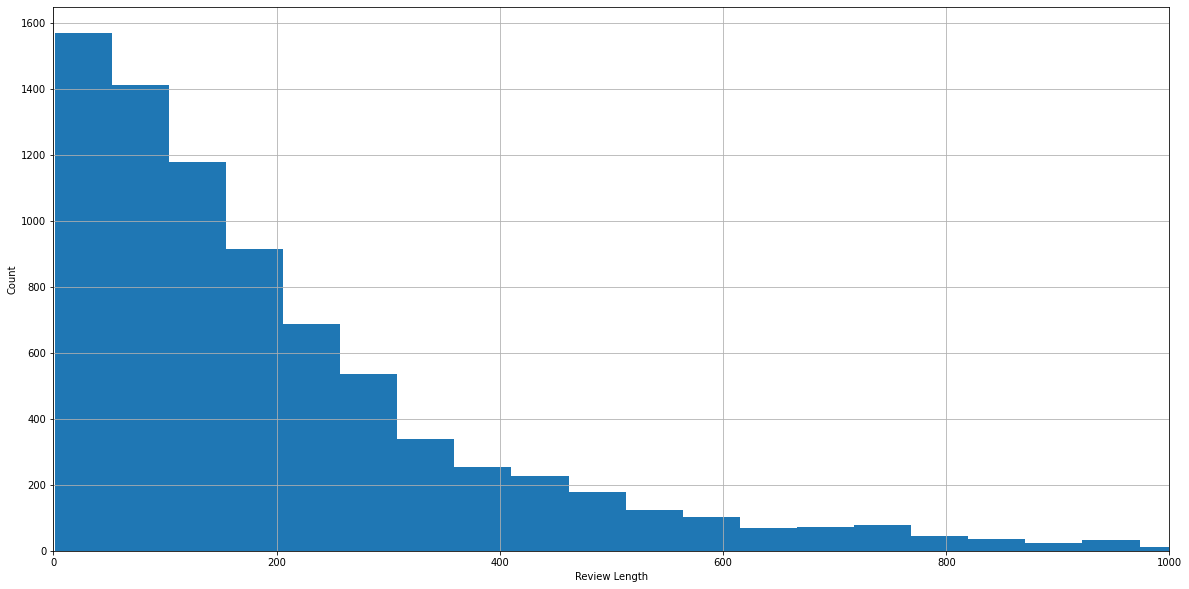

In [191]:
# Plot distribution of review lengths.
print(data.review_length.describe(percentiles = [0.25, 0.9, 0.95, 0.99]))
axarr = data.review_length.hist(bins = 100,figsize = (20,10))
axarr.set_xlabel("Review Length")
axarr.set_ylabel("Count")
axarr.set_xlim(0, 1000)

count    8070.000000
mean        7.641884
std         3.526348
min         4.000000
50%         7.000000
90%        12.000000
95%        15.000000
99%        20.000000
max        27.000000
Name: summary_length, dtype: float64


Text(0, 0.5, 'Count')

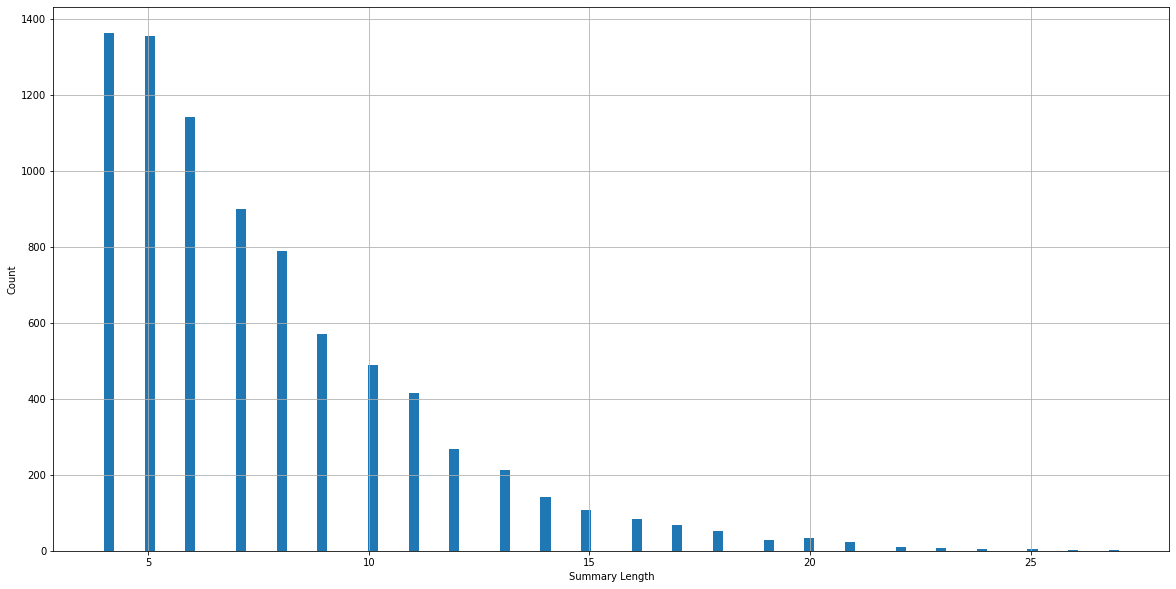

In [193]:
# Plot distribution of summary lengths.
print(data.summary_length.describe(percentiles = [0.9,0.95,0.99]))
axarr1 = data.summary_length.hist(bins = 100,figsize = (20,10))
axarr1.set_xlabel("Summary Length")
axarr1.set_ylabel("Count")

In [0]:
# Revome review summary pairs with summaries less than three words.
data = data[(data['summary_length'] > 3)]

In [72]:
# Final dataset size
len(data)

8070

In [0]:
# Split into training and validation set.
train_set = data.sample(frac=0.80, random_state=1537) 
test_set = data.drop(train_set.index)

In [74]:
print(len(train_set))
print(len(test_set))

6456
1614


In [75]:
train_set[:5]

,reviewText,summary,review_length,summary_length
5231,I have been through a large number of PC secur...,"Good product, but too much?",248,5
7057,Preliminary Review - - -\n\nI have used TurboT...,CAUTION !!! SCAM ALERT !!!,532,5
7609,There is no perfect AV software. Most aren't ...,Kaspersky continues to do the job right,88,7
6311,Norton Internet Security for MAC - a great pro...,"Just ok - great product IF it was needed, whic...",47,12
1307,I switched to mac after Vista problems. I love...,"Switched to the mac, LOVE LOVE LOVE it!",16,8


# Preprocess and Tokenize

In [0]:
# Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings.
def clean_text(text):
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    text = re.sub('\s{2,}', ' ', text)  
    
    return text

In [0]:
# Clean all reviews and summaries.
def clean_data(dataset, text_type):
  clean_texts = []
  for x in dataset[text_type]:
    clean_texts.append(clean_text(x).lower())
  return clean_texts


In [78]:
# Clean the summaries and texts
clean_summaries_train = clean_data(train_set, "summary")
print("Train summaries are complete.")

clean_summaries_test = clean_data(test_set, "summary")
print("Test summaries are complete.")

clean_reviews_train = clean_data(train_set, "reviewText")
print("Train reviews are complete.")

clean_reviews_test = clean_data(test_set, "reviewText")
print("Test reviews are complete.")

Train summaries are complete.
Test summaries are complete.
Train reviews are complete.
Test reviews are complete.


In [79]:
# Subset out any reviews and summaries that are longer than 512 tokens.
# Due to using BERT encoder.
subset_reviews_train = []
subset_summaries_train = []
for rev, summary in zip(clean_reviews_train, clean_summaries_train):
  if len(rev.split()) < 512:
    subset_reviews_train.append(rev)
    subset_summaries_train.append(summary)


subset_reviews_test = []
subset_summaries_test = []
for rev, summary in zip(clean_reviews_test, clean_summaries_test):
  if len(rev.split()) < 512:
    subset_reviews_test.append(rev)
    subset_summaries_test.append(summary)

print(len(subset_reviews_train))
print(len(subset_summaries_train))
print(len(subset_reviews_test))
print(len(subset_summaries_test))

5643
5643
1430
1430


In [80]:
# Map words to index. Create vocabulary for decoder.
word_to_ix = {'[PAD]':0, '<sos>':1, '<eos>':2, '[UNK]':3}

for sent in subset_reviews_train:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

for sent in subset_summaries_train:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

for sent in subset_reviews_test:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

for sent in subset_summaries_test:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

ix_to_word = {v:k for k, v in word_to_ix.items()}

VOCAB_SIZE = len(word_to_ix)

print(f"Vocabulary size is {len(word_to_ix)}")


Vocabulary size is 19360


In [0]:
# Tokenize and encode reviews and vocabulary. Able to handle out of vocab
# words by creating a tempory index and encoding with that value. 
def article2ids(article_words):
  ids = []
  oovs = []
  unk_id = word_to_ix['[UNK]']
  vocab_size = len(word_to_ix.keys())
  for w in article_words:
    i = word2id(w)
    if i == unk_id: 
      if w not in oovs: 
        oovs.append(w)
      oov_num = oovs.index(w) 
      ids.append(vocab_size + oov_num) 
    else:
      ids.append(i)
  return ids, oovs

# Checks if word is in dictionary.
def word2id(word):
  if word not in word_to_ix:
    return word_to_ix['[UNK]']
  return word_to_ix[word]

In [0]:
# Creates the boolean tags to take the first word piece.
def create_tags(tokenizer, review):
  reference_tags = []
  cur_bool = True
  words = review.split()
  for word in words:
    idxs = tokenizer.tokenize(word)
    for i in range(len(idxs)):
      if i == 0:
        reference_tags.append(cur_bool)
      else:
        cur_bool = False
        reference_tags.append(cur_bool)
      cur_bool = True
  return reference_tags

In [0]:
# Preprocess all reviews and summaries to be used in the model.
# Returns a BERT encoded source document, a boolean mask to get the 
# first word pieces, an encoding of the summaries with our own vocabulary
# , all OOV words, and an OOV encoding of the targets.
def preprocess(tokenizer, review, summary, oov_summary):
  review = " ".join(review.split(' '))
  src_subtoken_idxs = torch.tensor(tokenizer.encode(review, add_special_tokens=False)).unsqueeze(0)
  reference_tags = create_tags(tokenizer, review)

  if src_subtoken_idxs.shape[1] > 512:
      src_subtoken_idxs = src_subtoken_idxs.narrow(1, 0, 512)
      reference_tags = reference_tags[:512]


  tgt_idxs = [word_to_ix[w] if w in word_to_ix else word_to_ix['[UNK]'] for w in summary.split()]
  tgt_subtoken_idxs = torch.tensor(tgt_idxs, dtype=torch.long).unsqueeze(0)



  review_oov_idxs, review_oovs = article2ids(review.split()[:reference_tags.count(True)])
  summary_oov_idxs, summary_oovs = article2ids(oov_summary.split())
  tgt_oov_subtoken_idxs = torch.tensor(summary_oov_idxs, dtype=torch.long).unsqueeze(0)

  if reference_tags.count(True) != len(review_oov_idxs):
    print(reference_tags.count(True), len(review_oov_idxs))


  return src_subtoken_idxs, tgt_subtoken_idxs, review_oov_idxs, review_oovs, tgt_oov_subtoken_idxs, reference_tags

In [0]:
# Creates the dataset. Which is a list containing dictionaries
# that hold the items from the preprocess method.
def create_token_dataset(reviews, summaries):
  token_dataset = []
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  for review, summary in zip(reviews, summaries):
    orig_summary = "<sos> " + summary 
    oov_summary = summary + " <eos>"
    
    src_subtoken_idxs, tgt_subtoken_idxs, review_oov_idxs, review_oovs, summary_oov_idxs, reference_tags = preprocess(tokenizer, review, orig_summary, oov_summary)

    if src_subtoken_idxs.shape[1] > 512:
      src_subtoken_idxs = src_subtoken_idxs.narrow(1, 0, 512)
      reference_tags = reference_tags[:512]

    if tgt_subtoken_idxs.shape[1] > 512:
      tgt_subtoken_idxs = tgt_subtoken_idxs.narrow(1, 0, 512)

    if src_subtoken_idxs.shape[1] > 512:
      print("max len: ", src_subtoken_idxs.shape[1])

    if len(review_oov_idxs) > 512:
      print("review len: ", len(review_oov_idxs))

    review_data_dict = {"src": src_subtoken_idxs, "tgt":tgt_subtoken_idxs,
                        "src_oov_idx": review_oov_idxs, "srv_oovs": review_oovs,
                        "tgt_oov_idx": summary_oov_idxs, "ref_tags": reference_tags}
    token_dataset.append(review_data_dict)

  return token_dataset

In [85]:
# Tokenize and encode the dataset.
tokenized_reviews_train = create_token_dataset(subset_reviews_train, subset_summaries_train)
tokenized_reviews_test = create_token_dataset(subset_reviews_test, subset_summaries_test)

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [0]:
# Split validation set into validation and test set.
tokenized_reviews_validation = tokenized_reviews_test[:800]
tokenized_reviews_test = tokenized_reviews_test[800:]

# Model

Code from this section was influenced from a pytorch implementation of the PointerGen Model at this Github Page https://github.com/atulkum/pointer_summarizer

In [0]:
# Encoder class which is made up of a DistillBERT transformer. 
class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, decoder_hidden_dim):
    super(Encoder, self).__init__()
    hidden_dim = hidden_dim
    embed_dim = embed_dim
    dec_hidden_dim = decoder_hidden_dim

    self.hidden_dim = hidden_dim
    self.embed_dim = embed_dim
    self.dec_hidden_dim = dec_hidden_dim


    self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased', output_hidden_states=True)
    
    for param in self.bert.parameters():
      param.requires_grad = False

    self.bert.vocab_size = vocab_size
    self.map_2_decoder = nn.Linear(self.hidden_dim,  self.dec_hidden_dim).to(device)

    for param in self.parameters():
      param.requires_grad = False


  def forward(self, src, attn_mask, prep_tags):
    encoder_outputs = self.bert(src, attn_mask)
    output = encoder_outputs[0]
    output = output.contiguous()
    token_embeddings = [output[b][m] for b, m in enumerate(prep_tags)]
    output = pad_sequence(token_embeddings, batch_first=True)
    output_feature = output.view(-1, self.hidden_dim)
    output = self.map_2_decoder(output)
    output_feature = self.map_2_decoder(output_feature)
    hidden_states = encoder_outputs[1]
    second_2_last_hidden = hidden_states[-2]
    pooled_hidden = second_2_last_hidden.mean(1)
    pooled_cell = torch.zeros(1, pooled_hidden.shape[0], pooled_hidden.shape[1]).to(device)
    pooled_hidden = self.map_2_decoder(pooled_hidden)
    pooled_cell = self.map_2_decoder(pooled_cell)
    hidden = (pooled_hidden.view(1, pooled_hidden.shape[0], pooled_hidden.shape[1]), pooled_cell)

    return hidden, output, output_feature


In [0]:
# Attention class to be used in the decoder to calculate attention distribution.
class Attention(nn.Module):
  def __init__(self, hidden_dim):
      super(Attention, self).__init__()
      # attention
      self.hidden_dim = hidden_dim
      self.W_c = nn.Linear(1, self.hidden_dim, bias=False)
      self.decode_proj = nn.Linear(self.hidden_dim*2, self.hidden_dim)
      self.v = nn.Linear(self.hidden_dim, 1, bias=False)


  def forward(self, s_t_hat, encoder_outputs, encoder_feature, coverage):
      b, t_k, n = list(encoder_outputs.size())

      attention_mask = ~(encoder_outputs[:,:,0] == 0).to(device)

      dec_feat = self.decode_proj(s_t_hat) 
      dec_feat = dec_feat.unsqueeze(1)
      dec_feat_expanded = dec_feat.expand(b, t_k, n).contiguous() 
      dec_feat_expanded = dec_feat_expanded.view(-1, n)  

      att_features = encoder_feature.unsqueeze(0) + dec_feat_expanded
 
      coverage_input = coverage.view(-1, 1)  
      coverage_feature = self.W_c(coverage_input) 
      att_features = att_features + coverage_feature

      e = torch.tanh(att_features) 
      scores = self.v(e) 
      scores = scores.view(-1, t_k)

      attn_dist_ = F.softmax(scores, dim=1)*attention_mask
      normalization_factor = attn_dist_.sum(1, keepdim=True)
      attn_dist = attn_dist_ / normalization_factor

      attn_dist = attn_dist.unsqueeze(1)  
      c_t = torch.bmm(attn_dist, encoder_outputs)  
      c_t = c_t.view(-1, self.hidden_dim)  

      attn_dist = attn_dist.view(-1, t_k)  
      coverage = coverage.view(-1, t_k)
      coverage = coverage + attn_dist
    
      return c_t, attn_dist, coverage


In [0]:
# Decoder class to decode the hidden states and incorporate the attention 
# mechanism and calculate words of the output sequence.
class Decoder(nn.Module):
  
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.embed_dim = embed_dim
    self.output_dim = output_dim
    
    self.embed_layer = nn.Embedding(self.input_dim, self.embed_dim)
    self.prep_encoder = nn.Linear(768, self.hidden_dim)
    self.rnn = nn.LSTM(self.embed_dim, self.hidden_dim, batch_first=True)
    self.drop = nn.Dropout(p=.1)
    self.attention = Attention(self.hidden_dim)
    self.x_context = nn.Linear(self.hidden_dim*2 + self.embed_dim, self.embed_dim)
    self.point_gen = nn.Linear(self.hidden_dim*3 + self.embed_dim, 1)
    self.out = nn.Linear(self.hidden_dim*2, self.hidden_dim)
    self.final_out = nn.Linear(self.hidden_dim, self.output_dim)
  
  
  def forward(self, target_forced, hidden, encoder_output, encoder_feature, coverage, context_t_1, extended_vocab, extra_zeros, batch_size):

    target_embed = self.embed_layer(target_forced)
    x = self.x_context(torch.cat((context_t_1, target_embed), 1))
    output_rnn, (hidden_output, cell_output) = self.rnn(x.unsqueeze(1), hidden)

    output_rnn = self.drop(output_rnn)
    hidden_output = self.drop(hidden_output)
    cell_output = self.drop(cell_output)

    rnn_wts = torch.cat((hidden_output.view(-1, self.hidden_dim), 
                           cell_output.view(-1, self.hidden_dim)), 1)
    

    c_t, attn_dist, coverage_updated = self.attention(rnn_wts, encoder_output, encoder_feature, coverage)
    coverage = coverage_updated

    point_gen_input = torch.cat((c_t, rnn_wts, x), 1)
    point_gen = self.point_gen(point_gen_input)
    point_gen = torch.sigmoid(point_gen)

    output = torch.cat((output_rnn.view(-1, self.hidden_dim), c_t), 1)
    output = self.out(output)
    output = self.final_out(output)

    vocab_dist = F.softmax(output, dim=1)
    point_gen_vocab_dist = point_gen * vocab_dist
    point_gen_att_dist = (1 - point_gen) * attn_dist
    


    if extra_zeros is not None:
      point_gen_vocab_dist = torch.cat([point_gen_vocab_dist, extra_zeros], 1)



    if extended_vocab.shape != attn_dist.shape:
      print("extended_vocab", extended_vocab.shape)
      print("attn_dist", attn_dist.shape)
  
    final_dist = point_gen_vocab_dist.scatter_add(1, extended_vocab, attn_dist)

    
    return final_dist, hidden_output, cell_output, attn_dist, coverage 

In [0]:
# PointerGen class to create the final pytorch module which
# contains all the previous components.
class PointerGen(nn.Module):
    def __init__(self, encoder, decoder, is_eval=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if is_eval:
          self.encoder = encoder.eval()
          self.decoder = decoder.eval()       
    

# Train Utils

In [0]:
# Pad batches of data for the model.
def pad_data(data, pad_id, width=-1):
  if (width == -1):
      width = max(len(d) for d in data)
  rtn_data = [d + [pad_id] * (width - len(d)) for d in data]
  return rtn_data

In [0]:
# Pad wordpiece tags for the model.
def pad_tags(data, pad_id, width=-1):
  if (width == -1):
      width = max(len(d) for d in data)
  rtn_data = [d + [pad_id] * (width - len(d)) for d in data]
  return rtn_data

In [0]:
# Save the model weights to a local file. 
def save_model(model, optimizer):
  state = {
      'encoder_state_dict': model.encoder.state_dict(),
      'decoder_state_dict': model.decoder.state_dict(),
      'optimizer': optimizer.state_dict()
  }
  model_save_path = os.path.join("/content/drive/My Drive/DS 4420/Project/models/", 'model')
  torch.save(state, model_save_path)

# Train Methods

Code from this section was influenced from a pytorch implementation of the PointerGen Model at this Github Page https://github.com/atulkum/pointer_summarizer and the code from the Attention Is All You Need paper at this Github Page https://github.com/becxer/pointer-generator

In [0]:
import math

# Train method to train model and save losses and model locally.
def train(model, train_data, validation_data, batch_size, optimizer, num_epochs):
  running_avg_loss = 0.0
  running_avg_valid_loss = 0.0
  model.train()
  start = time.time()
  batch_size = batch_size
  
  train_losses = []
  validation_losses = []
  for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    epoch_loss_validation = 0.0
    random.shuffle(train_data)
    random.shuffle(validation_data)
    count = 0
    for i in range(0, len(train_data), batch_size):
      count +=1
      data_subset = train_data[i:i+batch_size]
      loss = train_batch(model, optimizer, data_subset, True)
      #print("train loss: ", loss)
      epoch_loss += loss

      if math.isnan(loss):
        print(count)
        print("loss: ", loss)
      if math.isnan(epoch_loss):
        print(count)
        print(epoch_loss)


    # Evaluate model on validation set
    for j in range(0, len(validation_data), batch_size):
        batch = validation_data[j:j+batch_size]

        with torch.no_grad(): 
          loss_validation = train_batch(model, optimizer, batch, False) 
          epoch_loss_validation += loss_validation

    train_losses.append(epoch_loss)
    validation_losses.append(epoch_loss_validation)
    tqdm.write(f"Train Loss (Epoch {epoch}) : {epoch_loss}")
    tqdm.write(f"Validation Loss (Epoch {epoch}) : {epoch_loss_validation}")


    f_train = open("/content/drive/My Drive/DS 4420/Project/loss/losses_train.txt", "a")
    f_validation = open("/content/drive/My Drive/DS 4420/Project/loss/losses_validation.txt", "a")
    f_train.write(str(epoch) + ", " + str(epoch_loss) + "\n")
    f_validation.write(str(epoch) + ", " + str(epoch_loss_validation) + "\n")


    if epoch % 10 == 0:
      print("model saved")
      torch.save({
            'epoch': epoch,
            'loss': epoch_loss,
            'model_state_dict': p_gen_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/My Drive/DS 4420/Project/models/model_trained")
      
    if epoch == 99:
      print("model saved")
      torch.save({
            'epoch': epoch,
            'loss': epoch_loss,
            'train_losses': train_losses,
            'validation_losses': validation_losses,
            'model_state_dict': p_gen_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/My Drive/DS 4420/Project/models/model_trained")
    
  return train_losses, validation_losses
  

In [0]:
import pdb

# Train one batch of data and calculate loss.
def train_batch(model, optimizer, batch, training):
  prep_reviews = [x['src'].tolist()[0] for x in batch]
  prep_targets = [x['tgt'].tolist()[0] for x in batch]
  prep_tags = [x['ref_tags'] for x in batch]
  prep_reviews_oov = [x['src_oov_idx'] for x in batch]
  prep_targets_oov = [x['tgt_oov_idx'].tolist()[0] for x in batch]
  dec_lens = [len(x['tgt'].tolist()[0]) for x in batch]
  dec_lens = torch.tensor(dec_lens).to(device)


  batch_reviews = torch.tensor(pad_data(prep_reviews, 0)).to(device)
  batch_targets = torch.tensor(pad_data(prep_targets, 0)).to(device)
  batch_extended_reviews = torch.tensor(pad_data(prep_reviews_oov, 0)).to(device)
  batch_extended_targets = torch.tensor(pad_data(prep_targets_oov, 0)).to(device)
  padded_prep_tags = pad_tags(prep_tags, False)


  batch_attn_mask = ~(batch_reviews == 0).to(device)
  batch_attn_mask_dec = ~(batch_targets == 0).to(device)
  batch_max_oovs = max([len(x['srv_oovs']) for x in batch])

  extra_zeros = None
  if batch_max_oovs > 0:
    extra_zeros = Variable(torch.zeros((batch_size, batch_max_oovs)))


  context_t_1 = Variable(torch.zeros(len(batch), 2*model.decoder.hidden_dim)).to(device)
  max_len = batch_targets.shape[1]
  vocab_size = model.decoder.output_dim

  step_losses = []
  
  if training:
    optimizer.zero_grad()

  hidden, encoder_output, encoder_feature = model.encoder(batch_reviews, batch_attn_mask, padded_prep_tags)
  coverage = Variable(torch.zeros(encoder_output.shape[0], encoder_output.shape[1])).to(device)

  for t in range(0, max_len):
      target_forced = batch_targets[:, t]
      final_dist, hidden_output, cell_output, point_gen_att_dist, next_coverage = \
      model.decoder(target_forced, hidden, encoder_output, encoder_feature, 
                    coverage, context_t_1, batch_extended_reviews, extra_zeros, len(batch))   

      target = batch_extended_targets[:, t]
      gold_probs = torch.gather(final_dist, 1, target.unsqueeze(1)).squeeze()
      step_loss = -torch.log(gold_probs + 1e-12)

      step_coverage_loss = torch.sum(torch.min(point_gen_att_dist, coverage), 1)
      step_loss = step_loss + step_coverage_loss
      # Update coverage
      coverage = next_coverage

      step_mask = batch_attn_mask_dec[:, t]
      step_loss = step_loss * step_mask
      step_losses.append(step_loss)
  
  sum_losses = torch.sum(torch.stack(step_losses, 1), 1)
  batch_avg_loss = sum_losses / dec_lens
  loss = torch.mean(batch_avg_loss)

  

  if math.isnan(loss):
    print("sum losses: ", sum_losses)
    print("seq lens: ", dec_lens)
    print("batch avg loss: ", batch_avg_loss)
    print("loss", loss)
    pdb.set_trace()
    print("loss before back: ", loss)
  
  if training:
    loss.backward()
    optimizer.step()

  return loss.item()

# Train Model

In [0]:
# embed_dim = 512
# hidden_dim_encoder = 768
# hidden_dim_decoder = 256
# vocab_size = 30522
# decoder_vocab_size= len(word_to_ix) 

# encoder = Encoder(vocab_size, embed_dim, hidden_dim_encoder, hidden_dim_decoder)
# decoder = Decoder(decoder_vocab_size, embed_dim, hidden_dim_decoder, decoder_vocab_size)

# p_gen_model = PointerGen(encoder, decoder).to(device)
# optimizer = optim.Adagrad(p_gen_model.parameters(), lr=0.01)

In [0]:
# Set model parameters.
embed_dim = 512
hidden_dim_encoder = 768
hidden_dim_decoder = 256
vocab_size = 30522
decoder_vocab_size= len(word_to_ix) 

# Initialize model parameters.
e = Encoder(vocab_size, embed_dim, hidden_dim_encoder, hidden_dim_decoder)
d = Decoder(decoder_vocab_size, embed_dim, hidden_dim_decoder, decoder_vocab_size)

# Initialize model and optimizer.
p_gen_model = PointerGen(e, d).to(device)
optimizer = optim.Adagrad(p_gen_model.parameters(), lr=0.01)

# Load in model and optimizer weights.
checkpoint = torch.load("/content/drive/My Drive/DS 4420/Project/models/model_trained")
p_gen_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [0]:
# Get number of parameters in the model.
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [116]:
# Number of parameters in the model.
get_n_params(p_gen_model)

83222177

In [50]:
# Train the model.
train_losses, validation_losses = train(p_gen_model, tokenized_reviews_train, tokenized_reviews_validation, 8, optimizer, 100)

Train Loss (Epoch 0) : 696.4081320762634
Validation Loss (Epoch 0) : 521.5600228309631
model saved
Train Loss (Epoch 1) : 694.6245937645435
Validation Loss (Epoch 1) : 517.8089389801025
Train Loss (Epoch 2) : 696.3484179973602
Validation Loss (Epoch 2) : 524.2287536859512
Train Loss (Epoch 3) : 698.9994866251945
Validation Loss (Epoch 3) : 521.6674904823303
Train Loss (Epoch 4) : 696.3905528187752
Validation Loss (Epoch 4) : 520.9916157722473
Train Loss (Epoch 5) : 690.0340883135796
Validation Loss (Epoch 5) : 522.2678681612015
Train Loss (Epoch 6) : 690.5128029286861
Validation Loss (Epoch 6) : 522.8696937561035
Train Loss (Epoch 7) : 695.4704436659813
Validation Loss (Epoch 7) : 524.4152100086212
Train Loss (Epoch 8) : 694.116880595684
Validation Loss (Epoch 8) : 523.7129027843475
Train Loss (Epoch 9) : 697.5944540202618
Validation Loss (Epoch 9) : 521.6955256462097
Train Loss (Epoch 10) : 690.3024416267872
Validation Loss (Epoch 10) : 520.1099997758865
model saved
Train Loss (Epoch 

In [0]:
# Save losses.
pickle.dump(train_losses, open("/content/drive/My Drive/DS 4420/Project/models/train_losses_1450_epochs.pickle", "wb"))
pickle.dump(validation_losses, open("/content/drive/My Drive/DS 4420/Project/models/valid_losses_1450_epochs.pickle", "wb"))

In [0]:
# Plot losses.
def plot(losses, labels):
  for i, loss_type in enumerate(losses):
    loss_values = losses[i]
    epochs = range(1, len(loss_values)+1)

    plt.plot(epochs, loss_values, label=labels[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses Over Training')
    plt.legend()

  plt.show()

In [0]:
# Load in loss files.
losses_50_train = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/train_losses_first_50_epochs.p", "rb" ))
losses_100_train = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/train_losses_first_100_epochs.p", "rb" ))
losses_150_train = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/train_losses_first_150_epochs.p", "rb" ))
losses_200_train = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/train_losses_first_200_epochs.p", "rb" ))

losses_50_validation = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/valid_losses_first_50_epochs.p", "rb" ))
losses_100_validation = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/valid_losses_first_100_epochs.p", "rb" ))
losses_150_validation = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/valid_losses_first_150_epochs.p", "rb" ))
losses_200_validation = pickle.load(open( "/content/drive/My Drive/DS 4420/Project/models/valid_losses_first_200_epochs.p", "rb" ))

In [0]:
# Combine losses.
train_losses = losses_50_train + losses_100_train + losses_150_train + losses_200_train
valid_losses = losses_50_validation + losses_100_validation + losses_150_validation + losses_200_validation

In [0]:
# Read in other loss files.
train_loss_file = pd.read_csv("/content/drive/My Drive/DS 4420/Project/loss/losses_train.txt", sep=',', lineterminator='\n', names=["epoch", "loss"], header=None)
valid_loss_file = pd.read_csv("/content/drive/My Drive/DS 4420/Project/loss/losses_validation.txt", sep=',', lineterminator='\n', names=["epoch", "loss"], header=None)

In [0]:
# Generate final losses.
rest_train_loss =  train_loss_file['loss'].to_list()
rest_valid_loss =  valid_loss_file['loss'].to_list()

train_losses = train_losses + rest_train_loss
valid_losses = valid_losses + rest_valid_loss

In [0]:
losses = []
losses.append(train_losses)
losses.append(valid_losses)

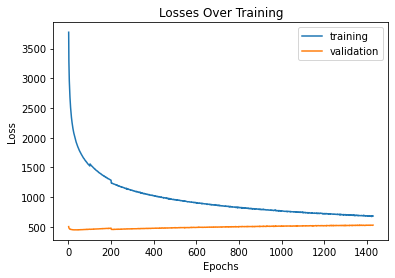

In [182]:
plot(losses, ['training', 'validation'])

# Evaluate

Code from this section was influenced from assignment 4 to help implement the beam search decoding strategy. The code can be found in this notebook https://colab.research.google.com/drive/1V24z4u7yWOs60RNcm9wLDMHBAaAncQN9

In [0]:
# Method to evaluate the test set and generate summaries from review.
def evaluate(model, data, optimizer, k):
  model.eval()
  start = time.time()
  batch_size = 1

  prep_reviews = [data['src'].tolist()[0]]
  prep_targets = [data['tgt'].tolist()[0]]
  prep_tags = [data['ref_tags']]
  prep_reviews_oov = [data['src_oov_idx']]
  prep_targets_oov = [data['tgt_oov_idx'].tolist()[0]]
  dec_lens = [len(data['tgt'].tolist()[0])]
  dec_lens = torch.tensor(dec_lens).to(device)


  batch_reviews = torch.tensor(pad_data(prep_reviews, 0)).to(device)
  batch_targets = torch.tensor(pad_data(prep_targets, 0)).to(device)
  batch_extended_reviews = torch.tensor(pad_data(prep_reviews_oov, 0)).to(device)
  batch_extended_targets = torch.tensor(pad_data(prep_targets_oov, 0)).to(device)
  padded_prep_tags = pad_tags(prep_tags, False)


  batch_attn_mask = ~(batch_reviews == 0).to(device)
  batch_attn_mask_dec = ~(batch_targets == 0).to(device)
  batch_max_oovs = len(data['srv_oovs'])

  extra_zeros = None
  if batch_max_oovs > 0:
    extra_zeros = Variable(torch.zeros((batch_size, batch_max_oovs)))


  context_t_1 = Variable(torch.zeros(1, 2*model.decoder.hidden_dim)).to(device)
  max_len = batch_targets.shape[1]
  vocab_size = model.decoder.output_dim

  hidden, encoder_output, encoder_feature = model.encoder(batch_reviews, batch_attn_mask, padded_prep_tags)
  coverage = Variable(torch.zeros(encoder_output.shape[0], encoder_output.shape[1])).to(device)
  
  outputs = torch.zeros(batch_size, max_len).long().to(device)
  outputs[:, 0] = 1

  outputs_tf = torch.zeros(batch_size, max_len).long().to(device)


  top_k_sequences = [[1]]
  top_k_scores = [0.0]


  for t in range(0, max_len):
    new_sequences = []
    new_scores = []
    for i, seq in enumerate(top_k_sequences):
      #target_forced = batch_targets[:, t]
      target_forced = torch.tensor(seq[t]).unsqueeze(0).to(device)
      final_dist, hidden_output, cell_output, point_gen_att_dist, next_coverage = \
      model.decoder(target_forced, hidden, encoder_output, encoder_feature, 
                  coverage, context_t_1, batch_extended_reviews, extra_zeros, 1)   

      word_scores = torch.log(final_dist)
      for j, score in enumerate(word_scores[0]):
        new_score = top_k_scores[i] + score.item()
        new_sequences.append(seq + [j])
        new_scores.append(new_score)

    top_k_index = np.argsort(new_scores)[-k:]
    top_k_sequences = [new_sequences[i] for i in top_k_index]
    top_k_scores = [new_scores[i] for i in top_k_index]



  output = top_k_sequences[0][1:]

  for i, val in enumerate(output):
    if val == 2:
      return output[1:i+1]
      
  return output[1:]

  # for t in range(0, max_len):
  #     target_forced = outputs_tf[:, t]
  #     final_dist, hidden_output, cell_output, point_gen_att_dist, next_coverage = \
  #     model.decoder(target_forced, hidden, encoder_output, encoder_feature, 
  #                 coverage, context_t_1, batch_extended_reviews, extra_zeros, 1)   

  #     outputs_tf[:, t] = final_dist.argmax()
  
  # return outputs_tf

          # argmax final_dist 
          # run through decoder function to get word from token value 

          

   

In [0]:
# Sample decoder outputs. Using a beam size of 5.
output_train = evaluate(p_gen_model, tokenized_reviews_train[1000], optimizer, 5)
output_test = evaluate(p_gen_model, tokenized_reviews_test[50], optimizer, 5)

In [160]:
# Train set original summary.
' '.join(ix_to_word[x] for x in tokenized_reviews_train[1000]['tgt_oov_idx'].tolist()[0])

'useful if you don t like your current protection <eos>'

In [161]:
# Train set generated summary.
' '.join(ix_to_word[x] for x in output_train)

'concept but norton <eos>'

In [166]:
# Test set original summary.
' '.join(ix_to_word[x] for x in tokenized_reviews_test[50]['tgt_oov_idx'].tolist()[0])

'good for small landlord business <eos>'

In [167]:
# Test set generated summary.
' '.join(ix_to_word[x] for x in output_test)

'tool <eos>'

In [0]:
# Method to decode outputs over the whole test set to be used to calculate 
# rouge scores. Summaries and their respective reviews written to local files.
def decode(model, data, optimizer, k):
  summaries = []
  reviews = []

  for d in data:
    output = evaluate(model, d, optimizer, k)

    summary = ' '.join(ix_to_word[x] for x in output)
    review = ' '.join(ix_to_word[x] for x in d['src_oov_idx'])

    summaries.append(summary)
    reviews.append(review)


    f_rev = open("/content/drive/My Drive/DS 4420/Project/reviews/review.txt", "a")
    f_summ = open("/content/drive/My Drive/DS 4420/Project/summaries/summary.txt", "a")

    f_rev.write(review + "\n")
    f_summ.write(summary + "\n")


In [174]:
count = 0
for d in tokenized_reviews_test:
    count += 1
    summary = ' '.join(ix_to_word[x] for x in d['tgt_oov_idx'].tolist()[0])

    f_summ = open("/content/drive/My Drive/DS 4420/Project/summaries/summary_reference.txt", "a")

    f_summ.write(summary + "\n")

print(count)

630


In [0]:
# Decode summaries.
decode(p_gen_model, tokenized_reviews_test[521:], optimizer, 5)

In [0]:
# There is a duplicate of one review and summary set because of an indexing
# miscalculation when Colab disconnected and had to restart the decoding process.

fname = "/content/drive/My Drive/DS 4420/Project/summaries/summary_refs.txt"
count = 0
with open(fname, 'r') as f:
    for line in f:
        count += 1
print("Total number of lines is:", count)

fname = "/content/drive/My Drive/DS 4420/Project/summaries/summary_tgt.txt"
count = 0
with open(fname, 'r') as f:
    for line in f:
        count += 1
print("Total number of lines is:", count)

In [0]:
# Calculate rouge scores for test set.
files_rouge = FilesRouge()
scores_final = files_rouge.get_scores("/content/drive/My Drive/DS 4420/Project/reviews/review.txt", 
                                "/content/drive/My Drive/DS 4420/Project/summaries/summary.txt", avg=True)


In [57]:
# Final rouge scores for the test set. 
scores_final

{'rouge-1': {'f': 0.06218302914764072,
  'p': 0.03950183733473425,
  'r': 0.4290850197750887},
 'rouge-2': {'f': 0.021883574474043696,
  'p': 0.013831811055136442,
  'r': 0.1573727849472011},
 'rouge-l': {'f': 0.0727909084868608,
  'p': 0.04426562268566457,
  'r': 0.4585600171971012}}